# Leios simulation analysis at tag `leios-2025w19`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Analysis of lifecycles and efficiencies

### Read the lifecycle results

In [2]:
lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
lifecycle[, `Kind`:=factor(`Kind`, levels=c("RB", "EB", "IB", "TX"))]
lifecycle[, `tps`:=factor(paste(`tps`, "tx/s"), levels=paste(c(1,3,10,30,100,300,1000), "tx/s"))]
lifecycle %>% summary

 simulator             tps          Kind                Item        
 rust:1466954   1 tx/s   :    734   RB:    239   0        :      7  
                3 tx/s   :   2009   EB:    654   0-node-33:      7  
                10 tx/s  :   6603   IB:  12992   0-node-91:      7  
                30 tx/s  :  19684   TX:1453069   1        :      7  
                100 tx/s :  67988                10       :      7  
                300 tx/s : 228135                100      :      7  
                1000 tx/s:1141801                (Other)  :1466912  
    Size [B]        References      Created [s]      To IB [s]     
 Min.   :     1   Min.   : 0.000   Min.   :  0.0   Min.   :  1.1   
 1st Qu.:   436   1st Qu.: 0.000   1st Qu.:149.7   1st Qu.:140.1   
 Median :   939   Median : 0.000   Median :300.1   Median :290.7   
 Mean   :  3427   Mean   : 1.022   Mean   :300.0   Mean   :292.4   
 3rd Qu.:  2033   3rd Qu.: 1.000   3rd Qu.:450.1   3rd Qu.:441.1   
 Max.   :196608   Max.   :12.000   Max. 

### Caveat

<font color="red">Beware that the plots below contain boundary effects that distort the statistics.</font>

### Size of persisted data

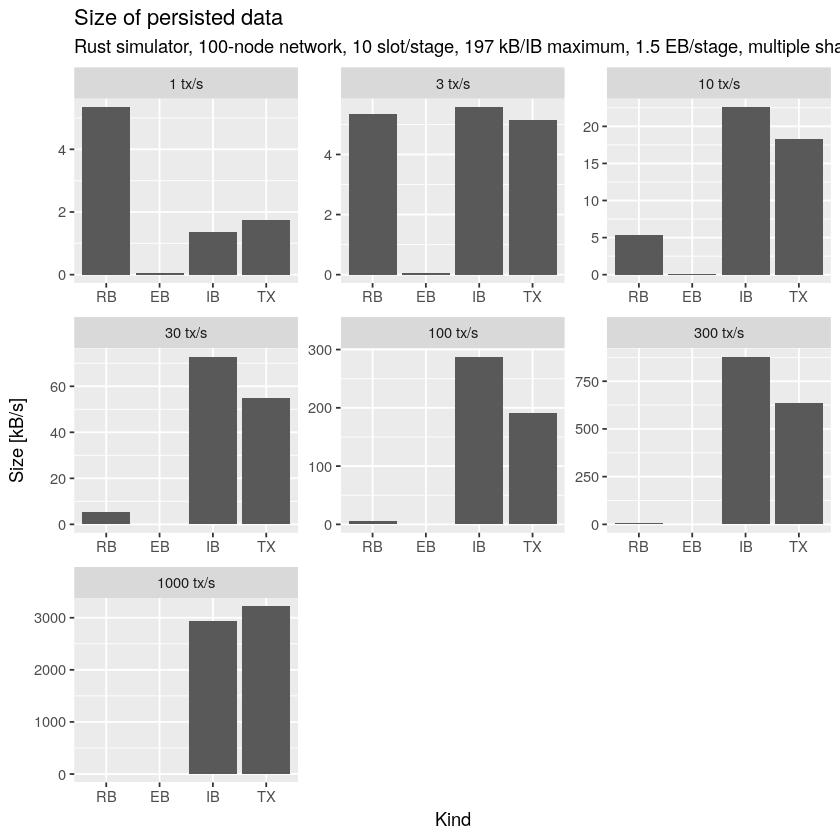

In [3]:
ggplot(
    lifecycle[, .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600), .(`Kind`, `TPS`=`tps`)],
    aes(x=`Kind`, y=`Size [kB/s]`)
) + geom_bar(stat="identity") +
    facet_wrap(`TPS` ~ ., scales="free") +
    ggtitle(
        "Size of persisted data",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [4]:
ggsave("plots/sizes.png", units="in", dpi=150, width=8, height=6)

In [5]:
ggsave("plots/sizes.svg", units="in", dpi=150, width=8, height=6)

### Spatial efficiency

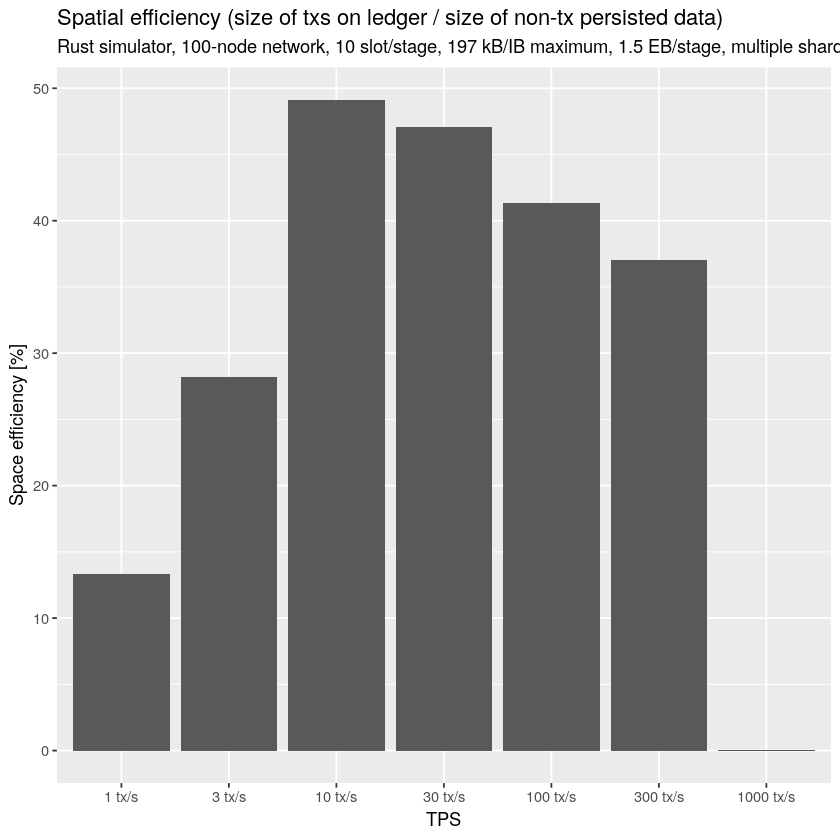

In [6]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`TPS`=`tps`)
    ][
        lifecycle[
            `Kind` != "TX", 
            .(`Non-tx size [B]`=sum(`Size [B]`)), 
            .(`TPS`=`tps`)
        ],
        on=c("TPS")
    ][, .(`TPS`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`TPS`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    ggtitle(
        "Spatial efficiency (size of txs on ledger / size of non-tx persisted data)",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [7]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [8]:
ggsave("plots/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

### Time to reach the ledger

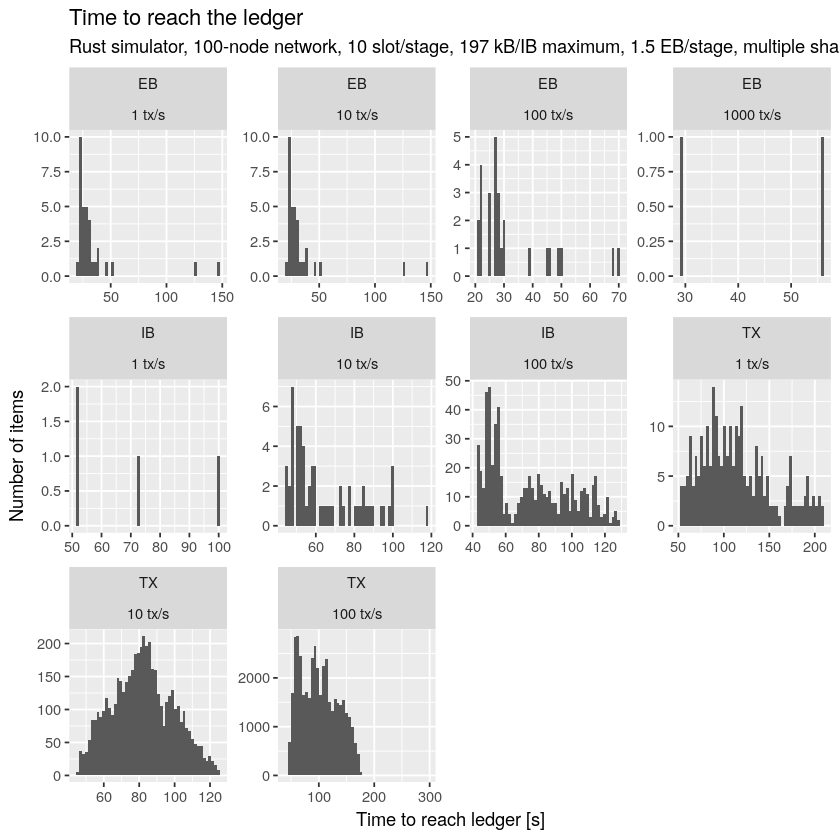

In [9]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To RB [s]`), 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [10]:
ggsave("plots/reach-rb.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("plots/reach-rb.svg", units="in", dpi=150, width=8, height=6)

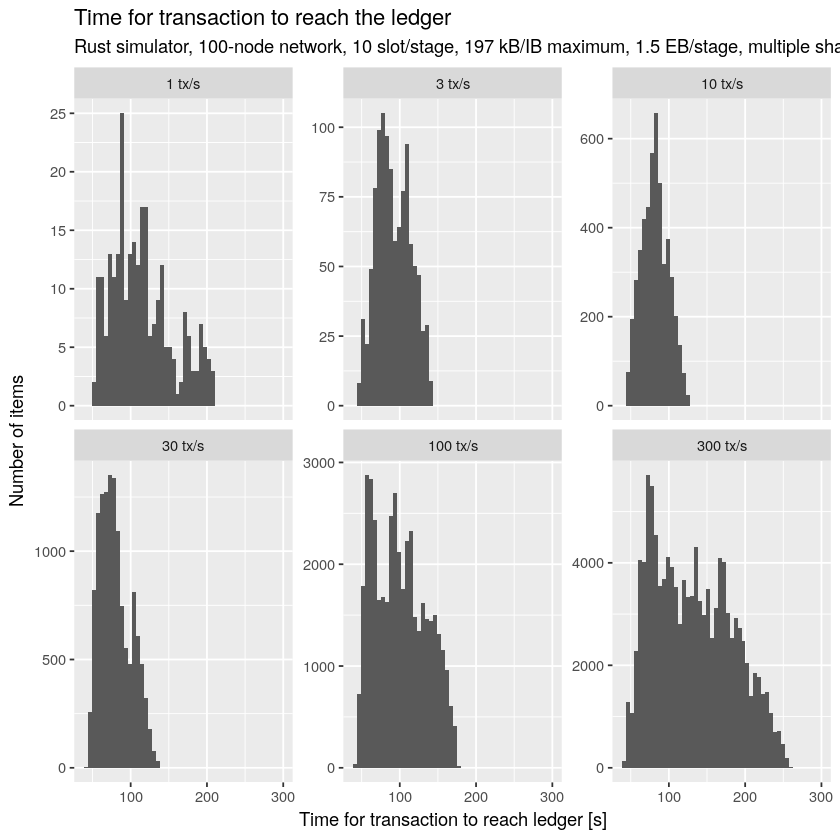

In [12]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`), 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach ledger [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(. ~ `tps`, scales="free_y", ncol=3) +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle(
        "Time for transaction to reach the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [13]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

In [14]:
ggsave("plots/reach-rb-tx.svg", units="in", dpi=150, width=8, height=6)

### Time to reach an EB

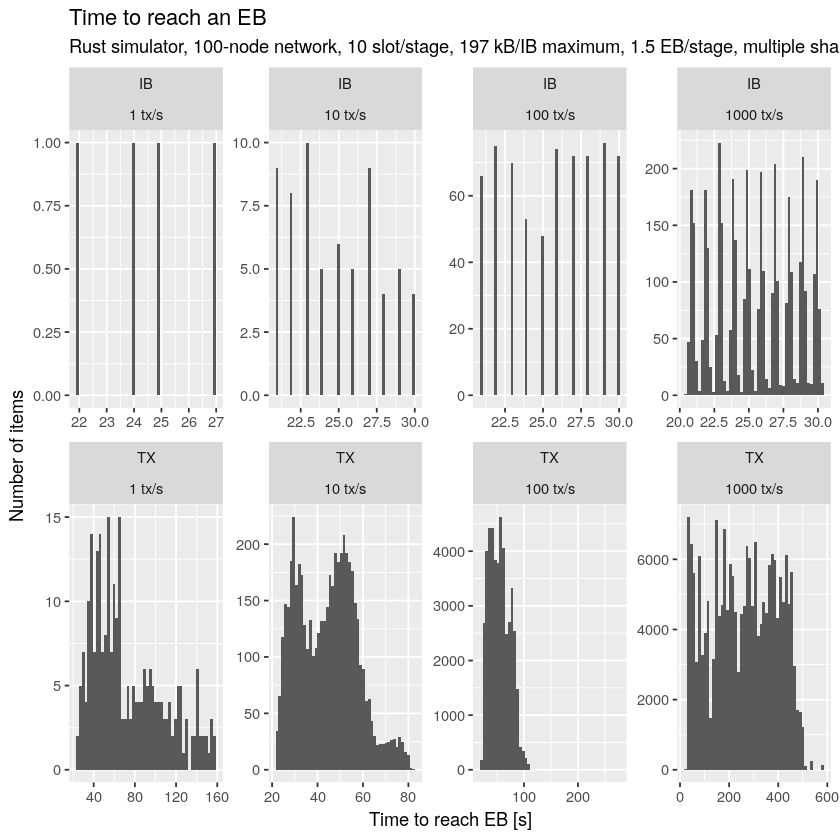

In [15]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To EB [s]`), 
        .(`Time to reach EB [s]`=`To EB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)
    ],
    aes(x=`Time to reach EB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach an EB",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [16]:
ggsave("plots/reach-eb.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/reach-eb.svg", units="in", dpi=150, width=8, height=6)

### Time to reach an IB

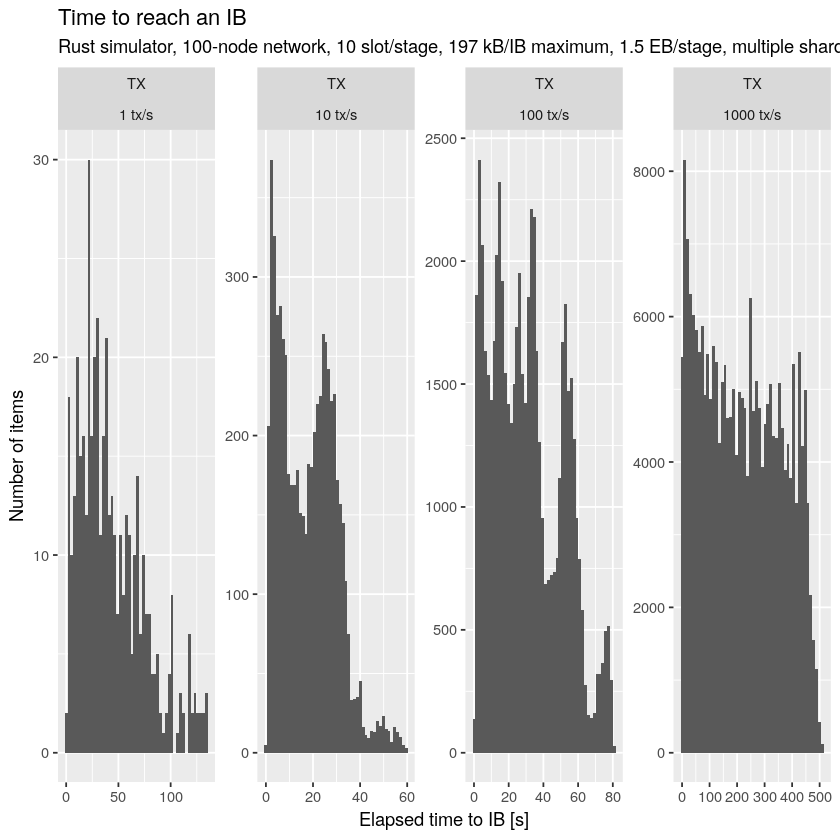

In [18]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX") & 
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s") & 
        !is.na(`To IB [s]`), 
        .(`Elapsed time to IB [s]`=`To IB [s]`-`Created [s]`), 
        .(`Kind`, `tps`)],
    aes(x=`Elapsed time to IB [s]`)
) + geom_histogram(bins=50) +
    facet_wrap(`Kind` ~ `tps`, scales="free", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Time to reach an IB",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [19]:
ggsave("plots/reach-ib.png", units="in", dpi=150, width=8, height=6)

In [20]:
ggsave("plots/reach-ib.svg", units="in", dpi=150, width=8, height=6)

### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

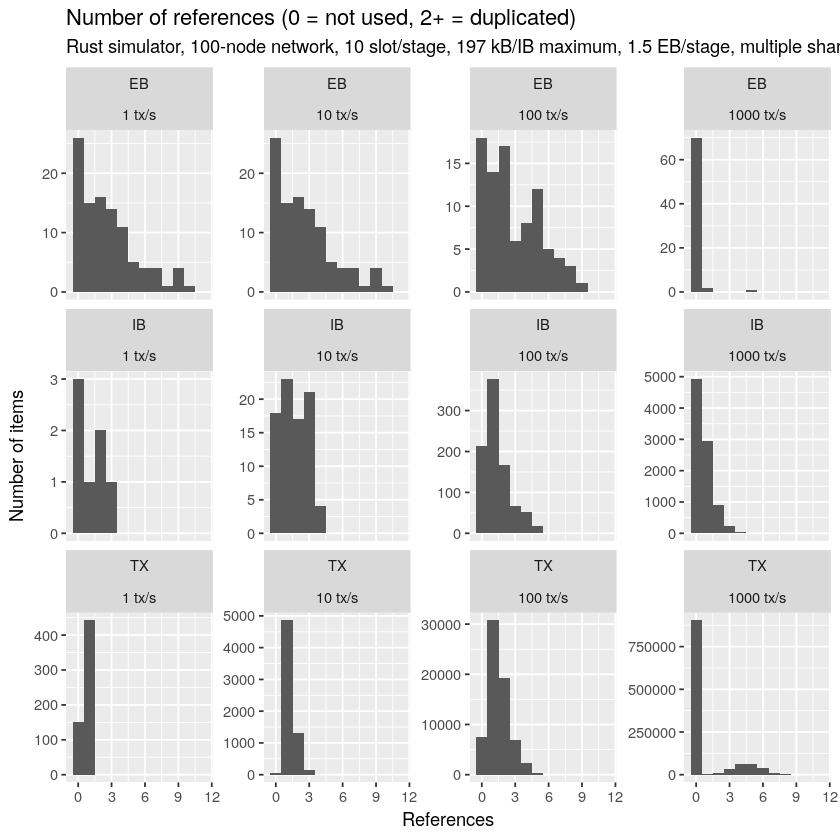

In [21]:
ggplot(
    lifecycle[
        `Kind` %in% c("TX", "IB", "EB") &
        `tps` %in% c("1 tx/s", "10 tx/s", "100 tx/s", "1000 tx/s")
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_wrap(`Kind` ~ `tps`, scales="free_y", ncol=4) +
    ylab("Number of items") +
    ggtitle(
        "Number of references (0 = not used, 2+ = duplicated)",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [22]:
ggsave("plots/references.png", units="in", dpi=150, width=8, height=6)

In [23]:
ggsave("plots/references.svg", units="in", dpi=150, width=8, height=6)

### Temporal efficiency

In [24]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        NA
}

In [25]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(ceiling(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `TPS`=`tps`
    )
][order(`TPS`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [26]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`TPS`, `Submitted [minute]`)]

#### Transactions reaching the ledger

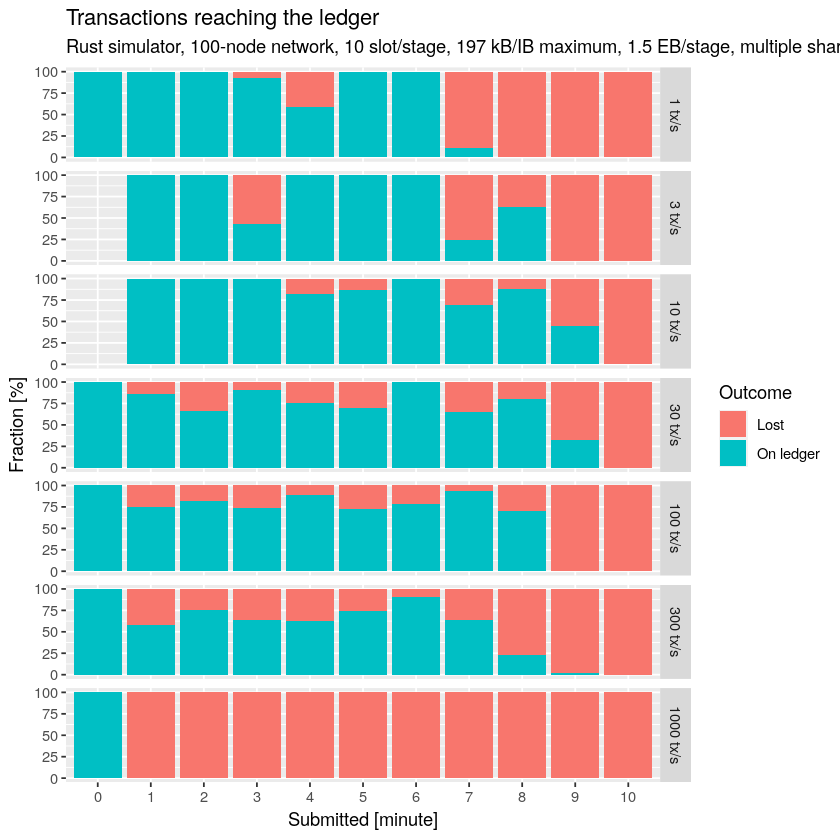

In [27]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`TPS`, `Submitted [minute]`)],
        id.vars=c("TPS", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[, .(
        `TPS`, 
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`TPS` ~ .) +
    ggtitle(
        "Transactions reaching the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [28]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("plots/temporal-efficiency-bar.svg", units="in", dpi=150, width=8, height=6)

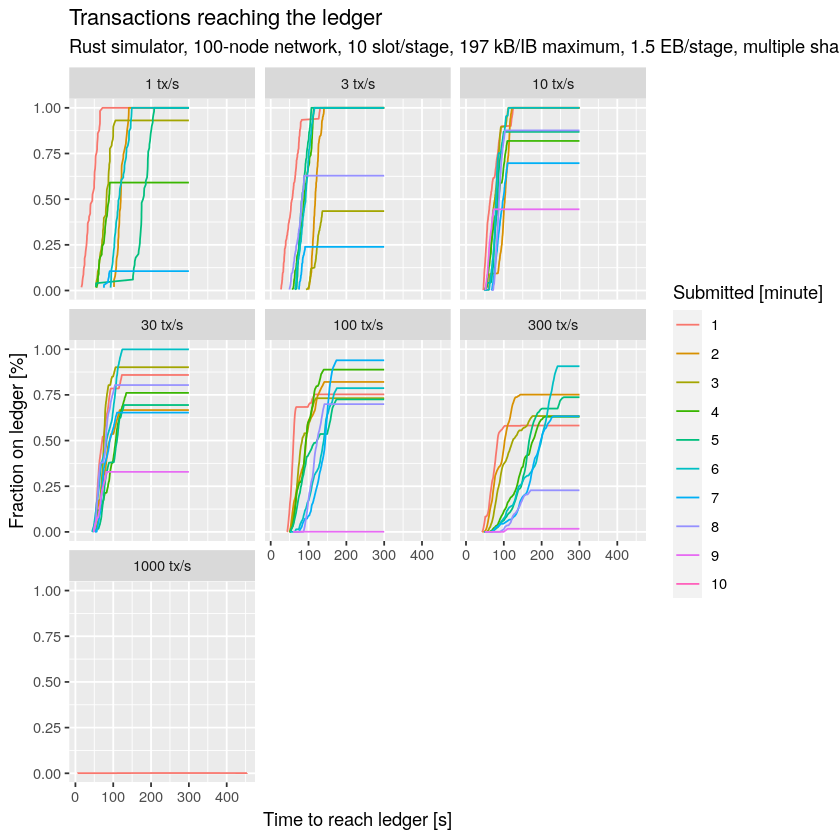

In [30]:
ggplot(
    rbind(
        totals[
            outcomes[!is.na(`Time to reach ledger [s]`), .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), .(`TPS`, `Submitted [minute]`)],
            on=c("TPS", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`TPS`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=300), .(`TPS`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 0],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_wrap(`TPS` ~ .) +
    ggtitle(
        "Transactions reaching the ledger",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [31]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

In [32]:
ggsave("plots/temporal-efficiency-timeseries.svg", units="in", dpi=150, width=8, height=6)

## Resource usage

In [33]:
resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
resources[, `tps`:=factor(paste(`tps`, "tx/s"), levels=paste(c(1,3,10,30,100,300,1000), "tx/s"))]
resources %>% summary

 simulator         tps           node         egress         
 rust:700   1 tx/s   :100   node-0 :  7   Min.   :3.473e+05  
            3 tx/s   :100   node-1 :  7   1st Qu.:1.264e+07  
            10 tx/s  :100   node-10:  7   Median :7.339e+07  
            30 tx/s  :100   node-11:  7   Mean   :2.889e+08  
            100 tx/s :100   node-12:  7   3rd Qu.:4.644e+08  
            300 tx/s :100   node-13:  7   Max.   :2.088e+09  
            1000 tx/s:100   (Other):658                      
      disk             total_cpu       maximum_cpu    
 Min.   :  4057122   Min.   : 16.78   Min.   :0.3095  
 1st Qu.:  6590401   1st Qu.: 20.74   1st Qu.:0.4177  
 Median : 46960048   Median : 78.78   Median :0.6722  
 Mean   :174229667   Mean   :249.16   Mean   :1.3813  
 3rd Qu.:438809952   3rd Qu.:598.92   3rd Qu.:2.1874  
 Max.   :530698982   Max.   :748.92   Max.   :4.4497  
                                                      

### Network

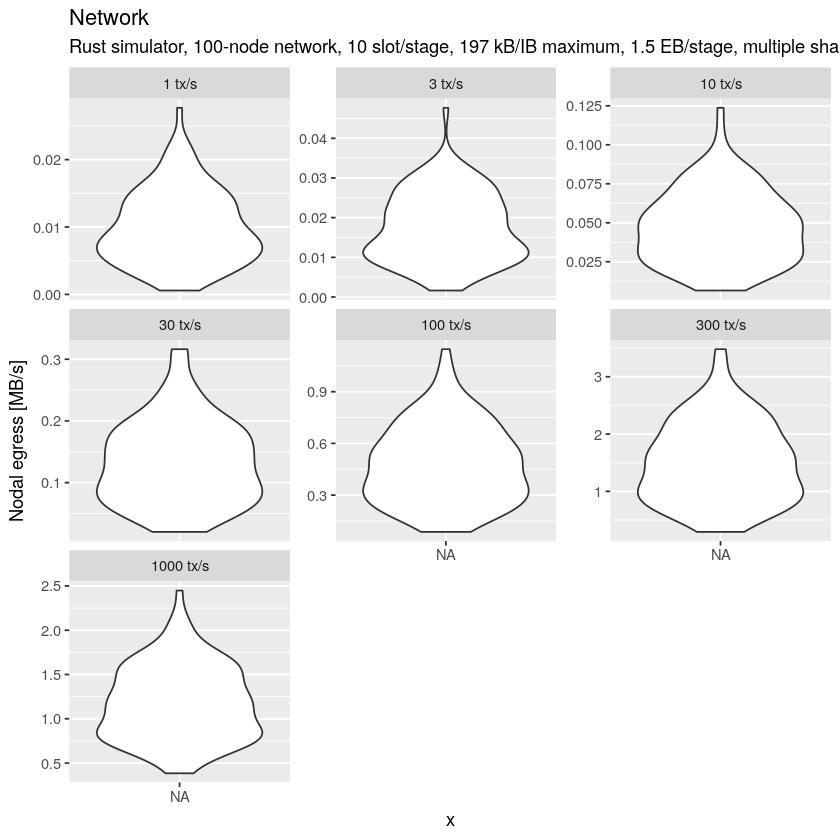

In [34]:
ggplot(
    resources[,
        .(
            `tps`,
            `node`,
            `Nodal egress [MB/s]`=`egress`/600/1e6
        )
    ], aes(x=NA, y=`Nodal egress [MB/s]`)
) +
    geom_violin() +
    facet_wrap(`tps` ~ ., scales="free_y") +
    ggtitle(
        "Network",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [35]:
ggsave("plots/network.png", units="in", dpi=150, width=9.5, height=5.5)

In [36]:
ggsave("plots/network.svg", units="in", dpi=150, width=9.5, height=5.5)

### Disk

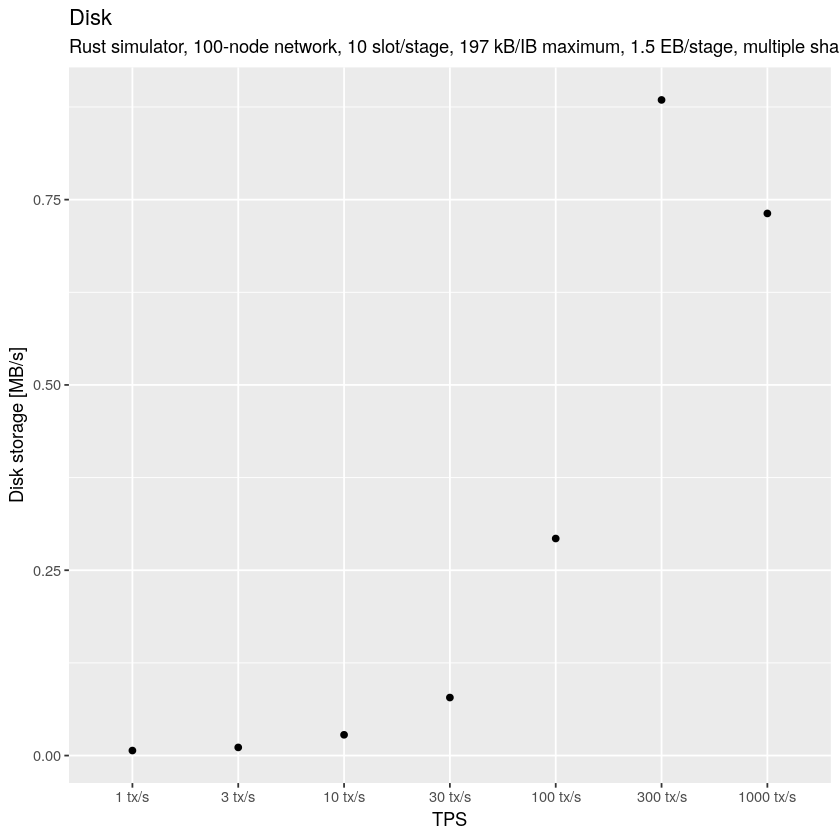

In [37]:
ggplot(
    resources[,
        .(`Disk storage [MB/s]`=mean(`disk`)/600/1e6),
        .(`TPS`=`tps`)
        
    ], aes(x=`TPS`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    ggtitle(
        "Disk",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [38]:
ggsave("plots/disk.png", units="in", dpi=150, width=9.5, height=5.5)

In [39]:
ggsave("plots/disk.svg", units="in", dpi=150, width=9.5, height=5.5)

### Peak CPU

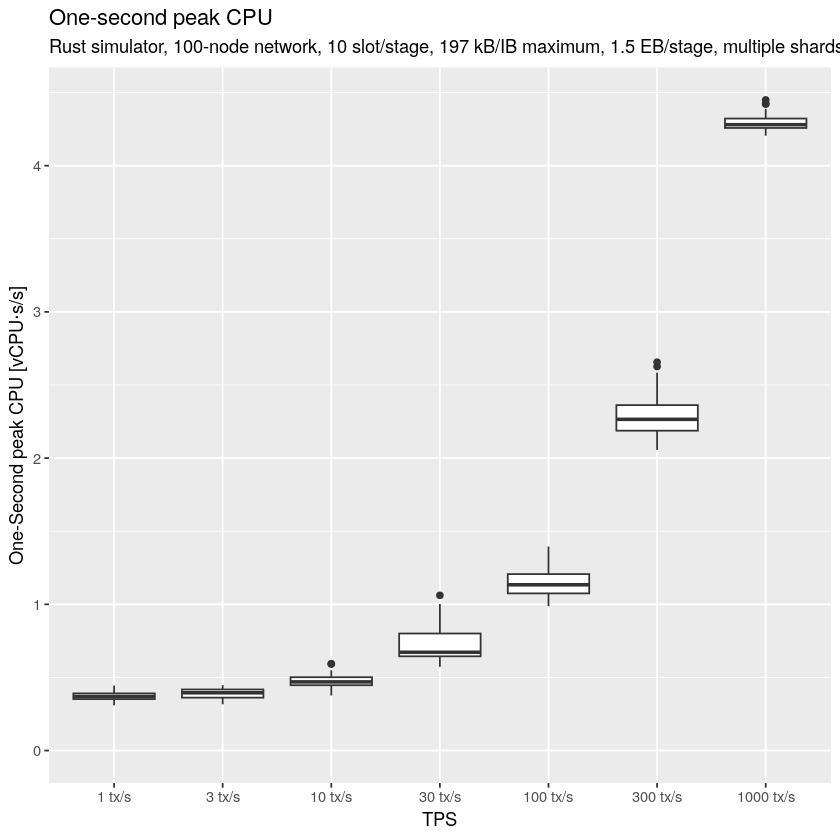

In [40]:
ggplot(
    resources[,
        .(
            `TPS`=`tps`,
            `node`,
            `One-Second peak CPU [vCPU⋅s/s]`=`maximum_cpu`
        )
    ], aes(x=`TPS`, y=`One-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle(
        "One-second peak CPU",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [41]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

In [42]:
ggsave("plots/cpu-peak.svg", units="in", dpi=150, width=9.5, height=5.5)

### Average CPU

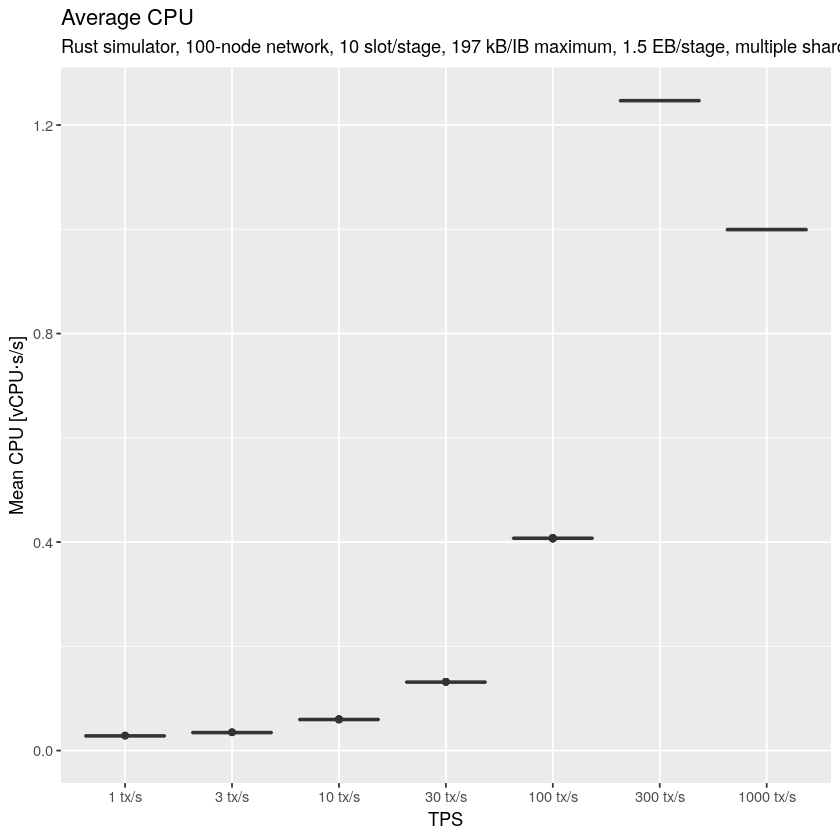

In [43]:
ggplot(
    resources[,
        .(
            `TPS`=`tps`,
            `node`,
            `Mean CPU [vCPU⋅s/s]`=`total_cpu`/600
        )
    ], aes(x=`TPS`, y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    ggtitle(
        "Average CPU",
        subtitle="Rust simulator, 100-node network, 10 slot/stage, 197 kB/IB maximum, 1.5 EB/stage, multiple shards"
    )

In [44]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

In [45]:
ggsave("plots/cpu-mean.svg", units="in", dpi=150, width=9.5, height=5.5)